In [13]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import modules as mod

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Plot the results for test 01 ... 

In [2]:
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
# First, load the results of the fit 

# set input params for the simulations 
tau_in = 575 # days 
SF_inf =  0.2 

# derived input params 
sigma_in = SF_inf  / np.sqrt(2)  # mags 
K_in = tau_in * SF_inf
sigma_hat_in = sigma_in * np.sqrt(2 / tau_in)

print('SF_inf = %.2f'%SF_inf)
print('tau_in = %.2f'%tau_in)
print('sigma_in =SF_inf / sqrt(2) =  %.4f'%sigma_in)
print('K_in = tau * sqrt(SF_inf) = %.3f'% K_in)
print('sigma_hat_in = sigma * sqrt(2 / tau) = %.5f'%sigma_hat_in)



SF_inf = 0.20
tau_in = 575.00
sigma_in =SF_inf / sqrt(2) =  0.1414
K_in = tau * sqrt(SF_inf) = 115.000
sigma_hat_in = sigma * sqrt(2 / tau) = 0.00834


Read in the results from results files ... 

In [20]:
import os
DIR = 'test_02_cadence_results/'
f = os.listdir(DIR)
m = np.asarray([x.startswith('resu') for x in f ])
f = np.asarray(f)[m]

N_iterations  = len(f)
results  = {}
for sampling in [1,2,4,8,16,32] : 
    results[sampling] = {} 
    prior = 'Jeff1'
    results[sampling][prior] = {
                       'sigma_MAP':np.zeros(N_iterations, dtype=float),
                       'tau_MAP':np.zeros(N_iterations, dtype=float),
                       'sigma_EXP':np.zeros(N_iterations, dtype=float),
                       'tau_EXP':np.zeros(N_iterations, dtype=float)}
        
print(N_iterations)       
# read in the results ... 
for file in f :
    
    results_i = np.load(DIR+file).item()
    i = int(file[len('results_'):-len('.npy')])
    #print(file,i )
    # populate the results 
    for sampling in results_i.keys():
        for param in results_i[sampling][prior].keys():
            results[sampling][prior][param][i] = results_i[sampling][prior][param]

1000


0.322713699172 0.291388053333 1
0.273993549988 0.236919597559 2
0.217824160852 0.167406260158 4
0.17286291089 0.100947910299 8
0.147638086518 0.0499699468114 16
0.14068102491 0.0195703112656 32


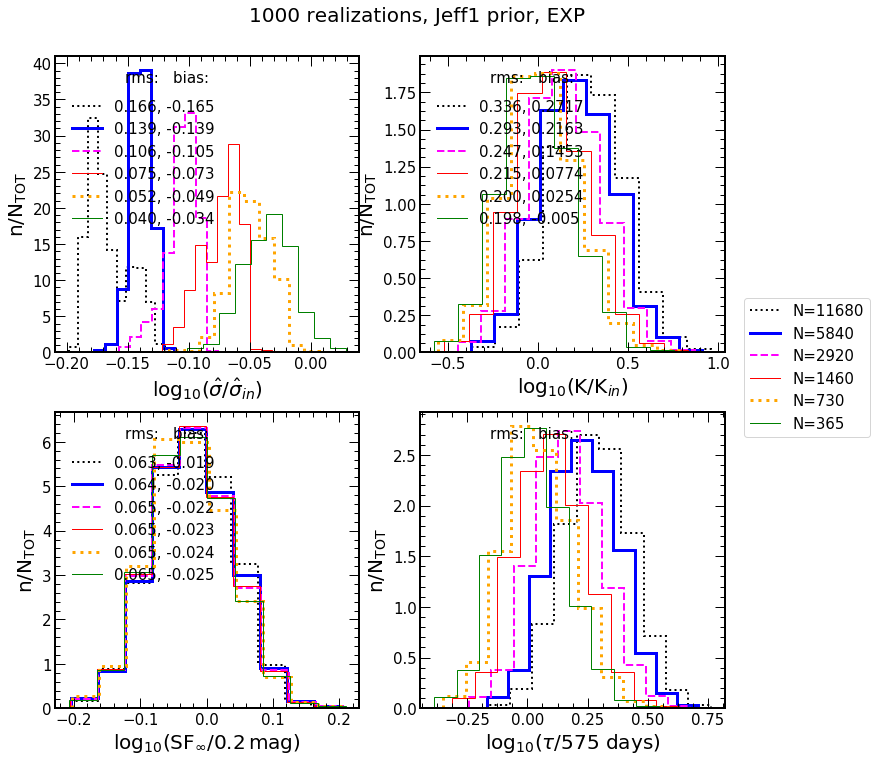

In [22]:
%matplotlib inline

prior = 'Jeff1' 
method = 'EXP'#'MAP'#'EXP'# 'MAP'

def plot_fig_15_macleod2011(results, prior, method, N_iterations, ):
    ''' A quick code to plot the equivalent of Fig15, 
    with the first test : we take 40-year long loght curve,
    anwe fit 1,3,10,40 - year sections. Given the input
    timescale of 575 days, this corresponds to  rho = tau / baseline  
    of 1.57, 0.52, 0.15,  0.03,   or log10(rho) = 0.19, -0.28,
    -0.80, -1.40  - to ease comparison fwith Fig2 of Kozlowski+2017.
    Shorter section of a long, 40 year long light curve with 
    constant, 10 day sampling, corresonds to shorter light curves with 
    les points, but the same cadence (sampling).
    
    '''
    return
# initialize the plotting space 
fig,axs = plt.subplots(2,2,figsize=(12,12))

suptitle = str(N_iterations)+' realizations, '+prior+ ' prior, ' + method
fig.text(0.35,0.92, suptitle, fontsize=20)
ax = np.ravel(axs)

# dotted and dashed have the same linewidth, 
# but the solid line for 10 years is thick, 
 # and for 1 year is thin 
ls_dic = {1:'dotted', 2:'solid', 4 :'dashed' , 8:'solid' , 16:'dotted', 32:'solid'}
lw_dic = {1:2,        2:3,       4: 2 ,        8:1       , 16:3,        32:1  }
color_dic = {1:'black',2:'blue', 4:'magenta',  8:'red' ,   16:'orange', 32:'green' }

ax_legend_handles = {0:[], 1:[], 2:[], 3:[]}
fig_legend_handles=[]
for sampling in [1,2,4,8,16,32] : 

    # fitted quantities : sigma , tau 
    tau_fit = results[sampling][prior]['tau_'+method]
    sigma_fit = results[sampling][prior]['sigma_'+method]

    # derived quantities : sigma_hat,  SF_inf , K 
    sigma_hat_fit = sigma_fit * np.sqrt(2 / tau_fit)
    SF_inf_fit = sigma_fit * np.sqrt(2)
    K_fit = tau_fit * SF_inf_fit
    
    # 0 : upper- left  , 1: upper-right  ,  2: bottom-left 
    # 3 : bottom-right 
    if prior is 'Jeff1' : 
        x = np.log10(sigma_hat_fit / sigma_hat_in)
        mask = (-0.22 < x)*( x<0.15)
        
        x_values_dic = {0:x[mask], 
                        1:np.log10(K_fit  / K_in), 
                        2:np.log10(SF_inf_fit / SF_inf), 
                        3:np.log10(tau_fit/ tau_in) 
                        }
    else: 
         x_values_dic = {0:np.log10(sigma_hat_fit / sigma_hat_in), 
                        1:np.log10(K_fit  / K_in), 
                        2:np.log10(SF_inf_fit / SF_inf), 
                        3:np.log10(tau_fit/ tau_in) 
                        }
    
    for i in range(len(ax)):
        
        x = x_values_dic[i]
        rms  = np.sqrt(np.mean(np.square(x)))
        bias = np.mean(x)
        if i == 3 : 
            print(rms, bias, sampling)
        ax[i].hist(x, histtype='step', ls = ls_dic[sampling],
                   lw=lw_dic[sampling], 
                   color = color_dic[sampling], 
                   normed=True)
        # need to make a line object to 
        # avoid getting a legend with a box ... 
        # https://matplotlib.org/users/legend_guide.html#plotting-guide-legend 
        line = mlines.Line2D([], [], color=color_dic[sampling],lw=lw_dic[sampling], 
                        ls = ls_dic[sampling],label=str(rms)[:5]+', '+str(bias)[:6])
        ax_legend_handles[i].append(line)
    
    # legend with length years 
    line = mlines.Line2D([], [], color=color_dic[sampling],lw=lw_dic[sampling], 
                    ls = ls_dic[sampling],label='N='+str(int((1460*8) / sampling)))
    fig_legend_handles.append(line)


# set labels,  ticks, etc : need to do only once ... 
xlabel_dic = {0:r'$\log_{10}{(\hat{\sigma} / \hat{\sigma}_{in})}$',
              1:r'$\log_{10}{(\mathrm{K}/\mathrm{K}_{in})}$',
              2:r'$\log_{10}{(\mathrm{SF}_{\infty} / 0.2\, \mathrm{mag})}$',
              3:r'$\log_{10}{(\tau / 575\,\, \mathrm{days})}$'
             }

for i in range(len(ax)):
    ax[i].set_xlabel(xlabel_dic[i])
    ax[i].set_ylabel(r'$\mathrm{n} / \mathrm{N}_{\mathrm{TOT}}$')
     # make ticks into the axis, longer and thicker... 
    minorLocator = AutoMinorLocator()
    ax[i].xaxis.set_minor_locator(minorLocator)
    minorLocator = AutoMinorLocator()
    ax[i].yaxis.set_minor_locator(minorLocator)

    ax[i].tick_params(which='both', direction='in', width='1')
    ax[i].tick_params(which='major', length=10)
    ax[i].tick_params(which='minor', length=5, color='black' ) 
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].legend(loc='upper left', handles = ax_legend_handles[i], frameon=False,
                bbox_to_anchor=(0.01, 0.9), fontsize=15)
    ax[i].text(0.23, 0.91, 'rms:   bias:',transform=ax[i].transAxes, fontsize=15)

# add legend with number of years
plt.legend(bbox_to_anchor=(1.04,1.15), loc="center left", 
           handles=fig_legend_handles, frameon=True,
           fontsize=15,)

plt.savefig('MacLeod_2011_Fig_15_02_'+prior+'_'+method+'.png', bbox_inches='tight')

In [67]:
fig.legend?